In [19]:
#setup imports and make ure the files we care about exist
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path

#custom modules
import feature_extraction
import unsw_nb15_dataset
import generator_discriminator


from importlib import reload #allow us to reload custom modules any time we like with modifications
reload(feature_extraction)
reload(unsw_nb15_dataset)
reload(generator_discriminator)

#fe.test_cases()

<module 'generator_discriminator' from '/home/jaywalker/MachineLearning/PacketGAN/generator_discriminator.py'>

In [20]:
#set some hyperparameters
sequence_length=25
batch_size=1

#first, load the dataset
data_set = unsw_nb15_dataset.UNSW_NB15('/home/jaywalker/MachineLearning/PacketGAN/UNSW_NB15_full_clean.csv',
                                       sequence_length=sequence_length, 
                                       transform=feature_extraction.build_feature_sequence_tensor)

#pick out the attack examples
data_set.use_only_category('DoS'); #in this case just look at DoS attack samples

#convert attack examples into time windows for training
#DONE by the UNSW_NB15 class at load-time

#convert each window into appropriate feature tensor
#DONE by the transform function passed to the UNSW_NB15 class at load-time

#train GAN to replace masked packets
#by iterating over the dataset for some # of epochs
#TODO make a python file to contain the network class definitions and training funciton

train_set_length = round(len(data_set) * 0.05)
test_set_length = train_set_length
excluded_set_length = len(data_set) - train_set_length - test_set_length
train_set, test_set, excluded_set = random_split(data_set, [train_set_length, test_set_length, excluded_set_length])

data_loader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=2)

data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
G = generator_discriminator.Generator(sequence_length, data_example.shape[2], data_example.shape[2] * 2, 30, data_example.shape[2], batch_size, torch.sigmoid)
D = generator_discriminator.Discriminator(sequence_length, data_example.shape[2], data_example.shape[2] * 2, 1, batch_size, torch.sigmoid)

/home/jaywalker/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Training has started...
Epoch:  0
D Real Error:  0.5986484289169312
D Fake Error:  0.6169734001159668
G Error:  0.930468738079071
Remaining time: 0:43:39.036741
Epoch:  1
D Real Error:  0.331894189119339
D Fake Error:  0.5899954438209534
G Error:  0.9513013958930969
Remaining time: 0:34:49.491525
Epoch:  2
D Real Error:  0.739044725894928
D Fake Error:  0.6457147002220154
G Error:  0.8229748606681824
Remaining time: 0:26:26.607002
Epoch:  3
D Real Error:  0.6092790365219116
D Fake Error:  0.754711389541626
G Error:  0.6525257229804993
Remaining time: 0:17:26.500233
Epoch:  4
D Real Error:  0.5675355195999146
D Fake Error:  0.7941465973854065
G Error:  0.6538677215576172
Remaining time: 0:08:42.762482


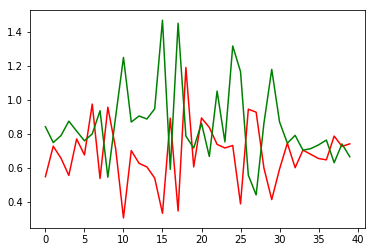

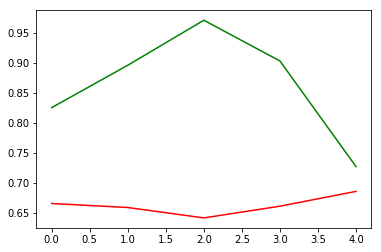

In [35]:
import train
reload(train)

#Train the network!
num_epochs = 5
G, D, g_losses, df_losses, g_stats, df_stats = train.train(G,D,data_loader,num_epochs)

#plot instantaneous losses
plt.plot(range(len(df_losses)), df_losses, 'r-', range(len(g_losses)), g_losses, 'g-')
plt.show()

#plot loss averages
plt.plot(range(len(df_stats.get_averages())), df_stats.get_averages(), 'r-', range(len(g_stats.get_averages())), g_stats.get_averages(), 'g-')
plt.show()

In [34]:
def print_dict_compare(dict1, dict2):
    for k in dict1:
        if k not in dict2:
            return None
        
    for k in dict1:
        print(dict1[k], "\t\t", dict2[k])

def dict_list_compare(dict_list1, dict_list2):
    for l in range(0, len(dict_list1)):
        print_dict_compare(dict_list1[l], dict_list2[l])
    print("\n\n")

            
import random
data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
print("Real data\tFake data")
real_data = feature_extraction.decode_feature_sequence_tensor(data_set, data_example[0])

#note here that "gen" is the trained generator returned from the training function above
generated_data = G(data_example).detach()
fake_data = feature_extraction.decode_feature_sequence_tensor(data_set, generated_data[0])

dict_list_compare(real_data, fake_data)

#print("From data set:")
#print(feature_extraction.decode_feature_sequence_tensor(data_set, data_set[0]))

Real data	Fake data
175.45.176.3 		 175.45.176.1
149.171.126.19 		 149.171.126.1
0 		 0
0 		 0
snp 		 unas
INT 		 INT
8.00000006262905e-06 		 4.781850460360722
200 		 10389
0 		 8906
254 		 252
0 		 1
0 		 3
0 		 4
100000003.23213577 		 2919308130.0204926
0.0 		 91742.28103740141
2 		 8
0 		 8
0 		 1
0 		 0
0 		 2371686
0 		 2241909
100 		 9
0 		 8
0 		 0
0 		 4318
0.0 		 873.0126943781997
0.0 		 462.0414697736666
1424230318 		 1414935254
1424230319 		 1417011474
0.00799999995181571 		 66.15973463527997
0.0 		 45.18959314737702
0.0 		 0.00753205579092796
0.0 		 0.003476390204408672
0.0 		 0.0036934934568275926
175.45.176.3 		 175.45.176.1
149.171.126.19 		 149.171.126.1
0 		 0
0 		 0
ipx-n-ip 		 unas
INT 		 INT
4.999999856234516e-06 		 4.650460073950076
200 		 10660
0 		 9048
254 		 252
0 		 1
0 		 3
0 		 4
160000005.17141724 		 2921562925.5489807
0.0 		 89464.86434159894
2 		 8
0 		 8
0 		 1
0 		 0
0 		 2385664
0 		 2217302
100 		 9
0 		 8
0 		 0
0 		 4235
0.0 		 868.3844540425624
0.0

100000003.23213577 		 2943110633.193405
0.0 		 89934.30174003076
2 		 8
0 		 8
0 		 1
0 		 0
0 		 2398813
0 		 2226397
100 		 9
0 		 8
0 		 0
0 		 4265
0.0 		 892.0338587240502
0.0 		 460.6424912688196
1424230318 		 1414930415
1424230319 		 1417009267
0.00799999995181571 		 65.61350607145344
0.0 		 45.227697974578476
0.0 		 0.007548568139859942
0.0 		 0.0035004559843386527
0.0 		 0.0036707888477083756
175.45.176.3 		 175.45.176.1
149.171.126.19 		 149.171.126.1
0 		 0
0 		 0
pgm 		 unas
INT 		 INT
8.00000006262905e-06 		 4.624638516605471
200 		 11061
0 		 9075
254 		 252
0 		 1
0 		 3
0 		 4
100000003.23213577 		 2984685243.7736053
0.0 		 88818.58408759348
2 		 8
0 		 8
0 		 1
0 		 0
0 		 2417559
0 		 2263925
100 		 9
0 		 8
0 		 0
0 		 4261
0.0 		 895.1275574621944
0.0 		 461.35255300628705
1424230318 		 1415134412
1424230319 		 1416925902
0.00799999995181571 		 64.85839016556227
0.0 		 45.51598237330327
0.0 		 0.0074875316927498214
0.0 		 0.0034390250808787534
0.0 		 0.0037418574218